```{index} single: solver; cbc
```
```{index} single: solver; cvxpy
```
```{index} single: solver; highs
```

# Extra material: Refinery production and shadow pricing with CVXPY

This is a simple linear optimization problem in six variables, but with four equality constraints it allows for a graphical explanation of some unusually large shadow prices for manufacturing capacity. The notebook presents also contrasts AMPL with CVXPY modeling.

In [1]:
# install AMPL and solvers
%pip install -q amplpy

SOLVER = "cbc"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["coin"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.4 MB/s eta 0:00:00
Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [2]:
%pip install -q cvxpy

This example derived from Example 19.3 from Seborg, Edgar, Mellichamp, and Doyle.

> Seborg, Dale E., Thomas F. Edgar, Duncan A. Mellichamp, and Francis J. Doyle III. Process dynamics and control. John Wiley & Sons, 2016.

The changes include updating prices, new solutions using optimization modeling languages, adding constraints, and adjusting parameter values to demonstrate the significance of duals and their interpretation as shadow prices.

## Problem data

In [3]:
import pandas as pd

products = pd.DataFrame(
    {
        "gasoline": {"capacity": 24000, "price": 108},
        "kerosine": {"capacity": 2000, "price": 72},
        "fuel oil": {"capacity": 6000, "price": 63},
        "residual": {"capacity": 2500, "price": 30},
    }
).T

crudes = pd.DataFrame(
    {
        "crude 1": {"available": 28000, "price": 72, "process_cost": 1.5},
        "crude 2": {"available": 15000, "price": 45, "process_cost": 3},
    }
).T

# note: volumetric yields may not add to 100%
yields = pd.DataFrame(
    {
        "crude 1": {"gasoline": 80, "kerosine": 5, "fuel oil": 10, "residual": 5},
        "crude 2": {"gasoline": 44, "kerosine": 10, "fuel oil": 36, "residual": 10},
    }
).T

display(products)
display(crudes)
display(yields)

capacity  price
gasoline     24000    108
kerosine      2000     72
fuel oil      6000     63
residual      2500     30

available  price  process_cost
crude 1    28000.0   72.0           1.5
crude 2    15000.0   45.0           3.0

gasoline  kerosine  fuel oil  residual
crude 1        80         5        10         5
crude 2        44        10        36        10

## AMPL Model

In [5]:
m = AMPL()

m.eval(
    """
    set CRUDES;
    set PRODUCTS;

    param price{PRODUCTS union CRUDES};
    param process_cost{CRUDES};
    param yields{PRODUCTS, CRUDES};
    param available{CRUDES};
    param capacity{PRODUCTS};

    # decision variables
    var x{c in CRUDES} >= 0 <= available[c];
    var y{p in PRODUCTS} >= 0 <= capacity[p];

    # objective
    var revenue = sum{p in PRODUCTS} price[p]*y[p];
    var feed_cost = sum{c in CRUDES} price[c]*x[c];
    var total_process_cost = sum{c in CRUDES} process_cost[c]*x[c];

    maximize profit: revenue - feed_cost - total_process_cost;

    # constraints
    subject to balances{p in PRODUCTS}:
        y[p] = sum{c in CRUDES} yields[p,c]*x[c] / 100;
"""
)

m.set_data(crudes, "CRUDES")
m.set_data(products, "PRODUCTS")
m.param["yields"] = yields.T

# solution
m.option["solver"] = SOLVER
m.solve(verbose=False)
print(f"Profit: {m.obj['profit'].value():0.2f}\n")

Profit: 860275.86



## CVXPY Model

The `CVXPY` library for disciplined convex optimization is tightly integrated with `numpy`, the standard Python library for the numerical linear algebra. For example, where `AMPL` uses explicit indexing in constraints, summations, and other objects, `CVXPY` uses the implicit indexing implied when doing matrix and vector operations.

Another sharp contrast with `AMPL` is that `CXVPY` has no specific object to describe a set,or to define a objects variables or other modeling objects over arbitrary sets. `CVXPY` instead uses the zero-based indexing familiar to Python users.

The following cell demonstrates these differences by presenting a `CVXPY` model for the small refinery example.

In [6]:
import numpy as np
import cvxpy as cp

# decision variables
x = cp.Variable(len(crudes.index), pos=True, name="crudes")
y = cp.Variable(len(products.index), pos=True, name="products")

# objective
revenue = products["price"].to_numpy().T @ y
feed_cost = crudes["price"].to_numpy().T @ x
process_cost = crudes["process_cost"].to_numpy().T @ x
profit = revenue - feed_cost - process_cost
objective = cp.Maximize(profit)

# constraints
balances = y == yields.to_numpy().T @ x / 100
feeds = x <= crudes["available"].to_numpy()
capacity = y <= products["capacity"].to_numpy()
constraints = [balances, feeds, capacity]

# solution
problem = cp.Problem(objective, constraints)
problem.solve()

860275.8615603454

## Crude oil feed results

In [7]:
results_crudes = crudes
results_crudes["consumption"] = x.value
results_crudes["shadow price"] = feeds.dual_value

display(results_crudes.round(1))

available  price  process_cost  consumption  shadow price
crude 1    28000.0   72.0           1.5      26206.9           0.0
crude 2    15000.0   45.0           3.0       6896.6           0.0

## Refinery production results

In [8]:
results_products = products
results_products["production"] = y.value
results_products["unused capacity"] = products["capacity"] - y.value
results_products["shadow price"] = capacity.dual_value

display(results_products.round(1))

capacity  price  production  unused capacity  shadow price
gasoline     24000    108     24000.0              0.0          14.0
kerosine      2000     72      2000.0              0.0         262.6
fuel oil      6000     63      5103.4            896.6           0.0
residual      2500     30      2000.0            500.0           0.0

## Why is the shadow price of kerosine so high?

(0.0, 24000.0)

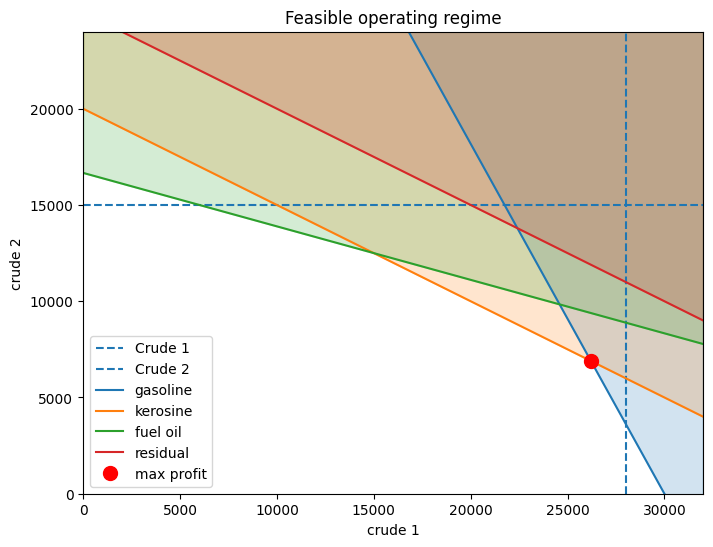

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
ylim = 24000
xlim = 32000

ax.axvline(crudes["available"][0], linestyle="--", label="Crude 1")
ax.axhline(crudes["available"][1], linestyle="--", label="Crude 2")

xplot = np.linspace(0, xlim)
for product in products.index:
    b = 100 * products.loc[product, "capacity"] / yields[product][1]
    m = -yields[product][0] / yields[product][1]
    line = ax.plot(xplot, m * xplot + b, label=product)
    ax.fill_between(xplot, m * xplot + b, 30000, color=line[0].get_color(), alpha=0.2)

ax.plot(x.value[0], x.value[1], "ro", ms=10, label="max profit")
ax.set_title("Feasible operating regime")
ax.set_xlabel(crudes.index[0])
ax.set_ylabel(crudes.index[1])
ax.legend()
ax.set_xlim(0, xlim)
ax.set_ylim(0, ylim)

## Suggested Exercises

1. Suppose the refinery makes a substantial investment to double kerosene production in order to increase profits. What becomes the limiting constraint?

2. How do prices of crude oil and refinery products change the location of the optimum operating point?

2. A refinery is a financial asset for the conversion of commodity crude oils into commodity hydrocarbons. What economic value can be assigned to owning the option to convert crude oils into other commodities?